In this Notebook, we present our filtering and analysis steps taken to produce the results and figures in the main manuscript.

## Table of Contents

* [Loading Libraries and Data](#s1)
* [VAST Challenge 2011 Data Facts](#s2)
* [Defining and Computing Metrics](#s3)
* [User Study](#s4)
    - [User Study Data Facts and Filtering](#s41)
    - [Metric Statistical Tests](#s42)
    - [Bookmarks Over Time Plot](#s43)
    - [Survey Response Visualization](#s44)
    - [Survey Response Statistical Tests](#s46)
    - [Geo-spatial Coverage Visualization](#s45)



<a id='s1'></a>
## Loading Libraries and Data

First we load the libraries needed as well and the data files:

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.feature_extraction.text import CountVectorizer
import json
import random
import collections
import math
import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as mpcm
import matplotlib.colors as mpc
from matplotlib import rc
import pickle
import ast
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.stats.api as sms

In [2]:
# VAST Challenge Dataset

# load the full VAST Challenge 2011 microblog dataset
all_data_microblogs = pd.read_pickle(f'../data/user_study/pickle/microblogs_dataset.pkl.gz', compression='gzip')

# list of keyword stems indicating a tweet is relevant
keywords = ['sore', 'throat', 'fever', 'fatigu', 'cough', 'short', 'breath', 'chill', 'sick', 
            'pain', 'diarrhea', 'stomach', 'sweat', 'pneumonia', 'flu', 'ach', 'nausea', 'vomit', 
            'nauseou', 'declin', 'health', 'headach', 'nose', 'runni']

# Label data points as relevant (1) or irrelevant (0) according to the keywords above
all_data_microblogs['label'] =  all_data_microblogs.apply(lambda row: int(any([w in keywords for w in row.porter_stems])), axis=1)

In [3]:
# Experiment Dataset

study_data_dir_1 = '../data/user_study/pickle/'

# load the data frame of sessions including session info, demographics, survey, and comments 
# (each row corresponds to one session)
df_sessions_1 = pd.read_pickle(f'{study_data_dir_1}/userstudy_sessions.pkl')

# load the log of bookmarks for all sessions
df_bookmarks_1 = pd.read_pickle(f'{study_data_dir_1}/userstudy_bookmarks.pkl')

# load the log of hovers for all sessions
df_hovers_1 = pd.read_pickle(f'{study_data_dir_1}/userstudy_hovers.pkl')

# load the ids of the random subset of 3000 points presented to subjects
subset_data_ids_1 = np.load(f'{study_data_dir_1}/sampled_ids_3000.npy')

<a id='s2'></a>
## VAST Challenge 2011 Data Facts

The proportion of relevant data points in the entire dataset:

In [4]:
all_data_microblogs.label.sum()/len(all_data_microblogs)

0.08448044477590641

The proportion of relevant data points in the __high-incidence__ set (used in user study):

In [5]:
subset_data_microblogs = all_data_microblogs.loc[subset_data_ids_1]
subset_data_microblogs.label.sum()/len(subset_data_microblogs)

0.3373333333333333

The _daily_ proportion of relevant data points:

In [6]:
temp = all_data_microblogs[['post_date_time', 'label']].copy()
temp['date'] = temp.apply(lambda row: row.post_date_time.split(' ')[0], axis=1)
temp['total'] = 1
temp = temp[['date', 'label', 'total']]
temp = temp.groupby('date').sum()
temp['incidence_rate'] = temp['label']/temp['total']
temp

,label,total,incidence_rate
date,,,
4/30/2011,958,44336,0.021608
5/1/2011,1022,45257,0.022582
5/10/2011,1034,44766,0.023098
5/11/2011,988,46785,0.021118
5/12/2011,999,45239,0.022083
5/13/2011,1069,46667,0.022907
5/14/2011,1034,45556,0.022697
5/15/2011,1070,44964,0.023797
5/16/2011,981,48975,0.020031


<a id='s3'></a>
## Defining and Computing Metrics

Below, we compute desired metrics from the interaction data for both experiments.

In [7]:

# Bookmarks
df_bookmarks_1['total_bookmark'] = df_bookmarks_1.apply(lambda row: int(row.feedback=='bookmark'), axis=1)
df_bookmarks_1['positive_bookmark'] = df_bookmarks_1.apply(lambda row: all_data_microblogs['label'].loc[int(row.point_id)] if row.feedback=='bookmark' else 0, axis=1)

df_bookmarks_1['total_unbookmark'] = df_bookmarks_1.apply(lambda row: int(row.feedback=='unbookmark'), axis=1)
df_bookmarks_1['positive_unbookmark'] = df_bookmarks_1.apply(lambda row: all_data_microblogs['label'].loc[int(row.point_id)] if row.feedback=='unbookmark' else 0, axis=1)
df_bookmarks_1['current_positive_bookmark_count'] = df_bookmarks_1.apply(lambda row: sum([all_data_microblogs['label'].loc[int(i)] for i in row.current_bookmark_list]) if row.feedback=='bookmark' else 0, axis=1)

df_bookmarks_1['total_irrelevant'] = df_bookmarks_1.apply(lambda row: int(row.feedback=='irrelevant'), axis=1)
df_bookmarks_1['positive_irrelevant'] = df_bookmarks_1.apply(lambda row: all_data_microblogs['label'].loc[int(row.point_id)] if row.feedback=='irrelevant' else 0, axis=1)

df_bookmarks_1['suggestion_bookmark'] = df_bookmarks_1.apply(lambda row: int(row.point_id in row.shifted_suggestion_list) if row.feedback=='bookmark' else 0, axis=1)
df_bookmarks_1['suggestion_irrelevant'] = df_bookmarks_1.apply(lambda row: int(row.point_id in row.shifted_suggestion_list) if row.feedback=='irrelevant' else 0, axis=1)

df_bookmarks_1['positive_suggestions'] = df_bookmarks_1.apply(lambda row: int(sum([all_data_microblogs['label'].loc[int(i)] for i in row.current_suggestion_list])), axis=1)
df_bookmarks_1['total_suggestions'] = df_bookmarks_1.apply(lambda row: int(sum([1 for i in row.current_suggestion_list])), axis=1)


df_bookmarks_1['current_unique_kw_count'] = df_bookmarks_1.apply(lambda row: len(np.unique([w for i in row['current_bookmark_list'] for w in all_data_microblogs.loc[i].porter_stems if w in keywords])), axis=1)
df_bookmarks_1['time_since_start'] = df_bookmarks_1.apply(lambda row: (row['time'] - df_bookmarks_1[df_bookmarks_1['session_id'] == row.session_id]['time'].min()).total_seconds()/60, axis=1)

headers = ['session_id', 'total_bookmark', 'positive_bookmark', 'total_unbookmark', 'positive_unbookmark', 'total_irrelevant', 'positive_irrelevant', 'suggestion_bookmark', 'suggestion_irrelevant', 'positive_suggestions', 'total_suggestions']
df_sessions_1 = df_sessions_1.join(df_bookmarks_1[headers].groupby('session_id').sum())

df_sessions_1['non_unique_suggestions_purity'] = df_sessions_1.positive_suggestions / df_sessions_1.total_suggestions

df_sessions_1 = df_sessions_1.join(df_bookmarks_1[['session_id', 'current_suggestion_list']].groupby('session_id').sum())
df_sessions_1['unique_suggestions'] = df_sessions_1.apply(lambda row: np.unique(row.current_suggestion_list), axis=1)
df_sessions_1['unique_suggestions'] = df_sessions_1.apply(lambda row: row.unique_suggestions[~np.isnan(row.unique_suggestions)], axis=1)
df_sessions_1['unique_positive_suggestions'] = df_sessions_1.apply(lambda row: sum([all_data_microblogs['label'].loc[int(i)] for i in row.unique_suggestions]), axis=1)
df_sessions_1['unique_total_suggestions'] = df_sessions_1.apply(lambda row: len(row.unique_suggestions), axis=1)
df_sessions_1['unique_suggestions_purity'] = df_sessions_1.unique_positive_suggestions / df_sessions_1.unique_total_suggestions

# Hovers
df_hovers_1['total_hover_circle'] = df_hovers_1.apply(lambda row: int(row.feedback=='hover_circle'), axis=1)
df_hovers_1['positive_hover_circle'] = df_hovers_1.apply(lambda row: all_data_microblogs['label'].loc[int(row.point_id)] if row.feedback=='hover_circle' else 0, axis=1)

df_hovers_1['total_hover_tooltip'] = df_hovers_1.apply(lambda row: int(row.feedback=='hover_tooltip'), axis=1)
df_hovers_1['positive_hover_tooltip'] = df_hovers_1.apply(lambda row: all_data_microblogs['label'].loc[int(row.point_id)] if row.feedback=='hover_tooltip' else 0, axis=1)

df_hovers_1['total_hover_sidebar_bookmark'] = df_hovers_1.apply(lambda row: int(row.feedback=='hover_sidebar_bookmark'), axis=1)
df_hovers_1['positive_hover_sidebar_bookmark'] = df_hovers_1.apply(lambda row: all_data_microblogs['label'].loc[int(row.point_id)] if row.feedback=='hover_sidebar_bookmark' else 0, axis=1)

# Hovers are registered 300ms after the event. Adding 200ms puts us at the 500 ms mentioned in the paper.
hover_threshold = 200
df_hovers_1_filtered = df_hovers_1[(df_hovers_1.time_duration > hover_threshold)]
headers = ['session_id', 'total_hover_circle', 'positive_hover_circle', 'total_hover_tooltip', 'positive_hover_tooltip', 'total_hover_sidebar_bookmark', 'positive_hover_sidebar_bookmark']
df_sessions_1 = df_sessions_1.join(df_hovers_1_filtered[headers].groupby('session_id').sum())

bookmarks_per_session_df = df_bookmarks_1.groupby('session_id').tail(1).reset_index(drop=True)[['session_id', 'current_bookmark_list']]
bookmarks_per_session_df = bookmarks_per_session_df.set_index('session_id')
df_sessions_1['current_bookmark_list'] = df_sessions_1.apply(lambda row: list(bookmarks_per_session_df.loc[row.name])[0] if row.name in bookmarks_per_session_df.index.to_list() else [], axis=1)



# Unique Keywords Discovered per Session
def count_unique_keywords(session_id):
    session_interactions = df_bookmarks_1[df_bookmarks_1['session_id'] == session_id]
    session_interactions = session_interactions[session_interactions['feedback'] == 'bookmark']
    session_interactions_ids = session_interactions['point_id']
    i_words = []
    for i in session_interactions_ids:
        i_words = i_words + all_data_microblogs['porter_stems'].loc[int(i)]
    i_keywords = np.array([w for w in i_words if w in keywords])
    return len(np.unique(i_keywords))

df_sessions_1['unique_keyword_count'] = df_sessions_1.apply(lambda row: count_unique_keywords(row.name), axis=1)

<a id='s4'></a>
## User Study

<a id='s41'></a>
### User Study Dataset Facts and Filtering

__Initial Filtering Criteria:__ We initially filter our user study dataset by eliminating invalid sessions based on the following four criteria:

- Failed survey attention checks
- Reported technical issues
- Hovered on at least 10 data points, where a valid hover is one lasting at least 500 milliseconds as defined above
- Met the age requiremet of 18-65 years old

As shown below, these primary filtering criteria leave us with 74 subjects in the control group and 49 subjects in the active search group.

In [8]:
print('before any filtering')
df_sessions_1_filtered_1 = df_sessions_1
display(df_sessions_1_filtered_1.groupby('active_search_condition').count()['session_started'])

print('after step (1)')
df_sessions_1_filtered_1 = df_sessions_1_filtered_1[(df_sessions_1_filtered_1['q4'] == 2) & ((df_sessions_1_filtered_1['q8'] == 5) | (df_sessions_1_filtered_1['q8'].isnull()))]
display(df_sessions_1_filtered_1.groupby('active_search_condition').count()['session_started'])

print('after step (2)')
df_sessions_1_filtered_1 = df_sessions_1_filtered_1[(df_sessions_1_filtered_1['technical_issues'] != True)]
display(df_sessions_1_filtered_1.groupby('active_search_condition').count()['session_started'])


print('after step (3)')
df_sessions_1_filtered_1 = df_sessions_1_filtered_1[(df_sessions_1_filtered_1['total_hover_circle'] >= 10)]
display(df_sessions_1_filtered_1.groupby('active_search_condition').count()['session_started'])

print('after step (4)')
df_sessions_1_filtered_1 = df_sessions_1_filtered_1[(df_sessions_1_filtered_1['age'] <= 65) & (df_sessions_1_filtered_1['age'] >= 18)]
display(df_sessions_1_filtered_1.groupby('active_search_condition').count()['session_started'])


before any filtering


active_search_condition
control    80
greedy     50
Name: session_started, dtype: int64

after step (1)


active_search_condition
control    79
greedy     50
Name: session_started, dtype: int64

after step (2)


active_search_condition
control    79
greedy     49
Name: session_started, dtype: int64

after step (3)


active_search_condition
control    75
greedy     49
Name: session_started, dtype: int64

after step (4)


active_search_condition
control    74
greedy     49
Name: session_started, dtype: int64

Basic information on the subject pool:

In [9]:
print('sex:')
display(df_sessions_1_filtered_1.sex.value_counts())

print(f'age:\nmin: {df_sessions_1_filtered_1.age.min()}, max: {df_sessions_1_filtered_1.age.max()}, mean: {df_sessions_1_filtered_1.age.mean()}, sd: {df_sessions_1_filtered_1.age.std()}\n\n')

print('education:')
display(df_sessions_1_filtered_1.education.value_counts())

print(f'avg completion time: {df_sessions_1_filtered_1.session_duration_minutes.mean()}')


sex:


male        76
female      46
withdraw     1
Name: sex, dtype: int64

age:
min: 18, max: 62, mean: 35.73170731707317, sd: 8.863327623944196


education:


bachelors     61
highschool    35
associate     14
masters       11
doctorate      2
Name: education, dtype: int64

avg completion time: 11.987127371273713


Observe how much active search groups interacted with suggestions

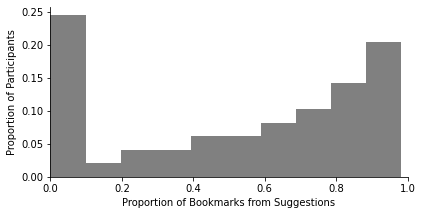

In [10]:
# Only considering subjects in the active search group (i.e. greedy)
plt.rcParams.update({'axes.titlesize': 10, 'axes.labelsize': 10, 'xtick.labelsize':10, 'xtick.labelsize':10})
plt_obj = plt.subplots(1, 1, figsize=(1*6.4, 0.65*4.8))
fig, ax = plt_obj

temp = df_sessions_1_filtered_1[df_sessions_1_filtered_1.active_search_condition == 'greedy']
((temp.suggestion_bookmark + temp.suggestion_irrelevant)/(temp.total_bookmark + temp.total_irrelevant)).hist(color='gray',grid=False, weights=1/len(temp)*np.ones(len(temp)), ax=ax)
ax.set(xlabel='Proportion of Bookmarks from Suggestions', ylabel='Proportion of Participants')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.rcParams.update({'axes.titlesize': 15, 'axes.labelsize': 15, 'xtick.labelsize':15})
ax.set_xlim((0, 1))
# ax.set_title('Experiment 1', size=12)


plt.savefig('../figure_outputs/rec_usage_pct_1.png', dpi=300, transparent=True, bbox_inches = 'tight',pad_inches = 0)

Given the bimodal distribution observed above, we add an additional layer of filtering to eliminate active search participants who did not interact with any recommendations.

Notice that 9 subjects in the active search group did not interact with recommendations. Therefore, after this additional filtering step, we have 74 subjects in the control group and 40 subjects in the active search group.

In [11]:
# Additional level of filtering to eliminate active search subjects who did not interact with bookmarks
df_sessions_1_filtered_2 = df_sessions_1[(df_sessions_1['q4'] == 2) & ((df_sessions_1['q8'] == 5) | (df_sessions_1['q8'].isnull())) & (df_sessions_1['total_hover_circle'] >= 10) & (df_sessions_1['technical_issues'] != True) & (df_sessions_1['age'] <= 65) & (df_sessions_1['age'] >= 18)]
df_sessions_1_filtered_2 = df_sessions_1_filtered_2[(df_sessions_1_filtered_2['active_search_condition'] == 'control') 
                                                | ((df_sessions_1_filtered_2['active_search_condition'] == 'greedy') &  (df_sessions_1_filtered_2['suggestion_bookmark'] != 0))]
df_sessions_1_filtered_2.groupby('active_search_condition').count()['session_started']

active_search_condition
control    74
greedy     40
Name: session_started, dtype: int64

In [12]:
temp = df_sessions_1_filtered_2[df_sessions_1_filtered_2.active_search_condition == 'greedy']

bookmark_purity = (temp.positive_bookmark/temp.total_bookmark).to_numpy().reshape(-1,1)
suggestion_purity = temp.unique_suggestions_purity.to_numpy()
# plt.scatter(bookmark_purity, suggestion_purity)
print(f'suggestion purity: {suggestion_purity.mean()} +/- {1.96*st.sem(suggestion_purity)}')

reg = LinearRegression()
reg.fit(bookmark_purity, suggestion_purity)

#print("The linear model is: suggestion_purity = {:.5} + {:.5}bookmark_purity\n".format(reg.intercept_[0], reg.coef_[0][0]))
X = bookmark_purity
y = suggestion_purity

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

suggestion purity: 0.7933930019984365 +/- 0.048405793222466194
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     57.98
Date:                Fri, 08 Jul 2022   Prob (F-statistic):           3.68e-09
Time:                        17:00:30   Log-Likelihood:                 36.545
No. Observations:                  40   AIC:                            -69.09
Df Residuals:                      38   BIC:                            -65.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [13]:
# active search group who ignored suggestions
df_as_i = df_sessions_1_filtered_1[(df_sessions_1_filtered_1.active_search_condition == 'greedy') & 
                                   (df_sessions_1_filtered_1.suggestion_bookmark == 0)]

# active search group who used suggestions
df_as_u = df_sessions_1_filtered_1[(df_sessions_1_filtered_1.active_search_condition == 'greedy') & 
                                   (df_sessions_1_filtered_1.suggestion_bookmark != 0)]

print (f'Size of AS-I is {len(df_as_i)}\nSize of AS-U is {len(df_as_u)}\n\n')

print (f'For AS-I, the 95% CI for avg suggestion purity is {df_as_i.unique_suggestions_purity.mean()}+/- {1.96 * st.sem(df_as_i.unique_suggestions_purity)}')
print (f'For AS-U, the 95% CI for avg suggestion purity is {df_as_u.unique_suggestions_purity.mean()} +/- {1.96 * st.sem(df_as_u.unique_suggestions_purity)}\n\n')

print (f'For AS-I, the 95% CI for avg bookmark purity is {(df_as_i.positive_bookmark/df_as_i.total_bookmark).mean()} +/- {1.96 * st.sem((df_as_i.positive_bookmark/df_as_i.total_bookmark))}')
print (f'For AS-U, the 95% CI for avg bookmark purity is {(df_as_u.positive_bookmark/df_as_u.total_bookmark).mean()} +/- {1.96 * st.sem((df_as_u.positive_bookmark/df_as_u.total_bookmark))}\n\n')


Size of AS-I is 9
Size of AS-U is 40


For AS-I, the 95% CI for avg suggestion purity is 0.8171253007787627+/- 0.08971809044976077
For AS-U, the 95% CI for avg suggestion purity is 0.7933930019984365 +/- 0.048405793222466194


For AS-I, the 95% CI for avg bookmark purity is 0.7593408070555908 +/- 0.1124754387097991
For AS-U, the 95% CI for avg bookmark purity is 0.8162266605286664 +/- 0.053290297743518886




<a id='s42'></a>
### Metric Statistical Tests

In the block below, we conduct two sample t-tests for our metrics. The values from this block are reported in the manuscript.

In [14]:
## Table 2, main manuscript
temp = df_sessions_1_filtered_2
temp['session_duration_minutes'] = temp.apply(lambda row: min(10, row.session_duration_minutes), axis=1)

temp1 = temp[temp.active_search_condition == 'control']
temp2 = temp[(temp['active_search_condition'] == 'greedy')]


print('T1: ', len(temp1), 'T2:', len(temp2), '\n\n')

# HPM
g1 = temp1.total_hover_circle / temp1.session_duration_minutes
g1 = g1.to_list()

g2 = temp2.total_hover_circle / temp2.session_duration_minutes
g2 = g2.to_list()

print('Hovers Per Minute:')
t, p = st.ttest_ind(g1, g2)
print(f'g1 = {np.mean(g1):.4f} ± {st.t.ppf(0.975, len(g1)-1)*np.std(g1)/math.sqrt(len(g1)):.4f}')
print(f'g2 = {np.mean(g2):.4f} ± {st.t.ppf(0.975, len(g2)-1)*np.std(g2)/math.sqrt(len(g2)):.4f}')
print(f'p-value={p:.4f}')
print(f't-statistic: {t:.2f}')
x_bar_1 = np.mean(g1)
x_bar_2 = np.mean(g2)
s_pooled = math.sqrt( ((len(g1)-1)*np.std(g1)**2+(len(g2)-1)*(np.std(g2)**2)) / (len(g2) + len(g1) - 2) )
print(f'effect size: {(x_bar_1 - x_bar_2)/s_pooled:.4f}\n')
print("\n\n\n")



# RHPM
g1 = temp1.positive_hover_circle / temp1.session_duration_minutes
g1 = g1.to_list()

g2 = temp2.positive_hover_circle / temp2.session_duration_minutes
g2 = g2.to_list()

print('Positive Hovers Per Minute:')
t, p = st.ttest_ind(g1, g2)
print(f'g1 = {np.mean(g1):.4f} ± {st.t.ppf(0.975, len(g1)-1)*np.std(g1)/math.sqrt(len(g1)):.4f}')
print(f'g2 = {np.mean(g2):.4f} ± {st.t.ppf(0.975, len(g2)-1)*np.std(g2)/math.sqrt(len(g2)):.4f}')
print(f'p-value={p:.4f}')
print(f't-statistic: {t:.2f}')
x_bar_1 = np.mean(g1)
x_bar_2 = np.mean(g2)
s_pooled = math.sqrt( ((len(g1)-1)*np.std(g1)**2+(len(g2)-1)*(np.std(g2)**2)) / (len(g2) + len(g1) - 2) )
print(f'effect size: {(x_bar_1 - x_bar_2)/s_pooled:.4f}\n')
print("\n\n\n")


# RH
g1 = temp1.positive_hover_circle
g1 = g1.to_list()

g2 = temp2.positive_hover_circle
g2 = g2.to_list()

print('Positive Hovers:')
t, p = st.ttest_ind(g1, g2)
print(f'g1 = {np.mean(g1):.4f} ± {st.t.ppf(0.975, len(g1)-1)*np.std(g1)/math.sqrt(len(g1)):.4f}')
print(f'g2 = {np.mean(g2):.4f} ± {st.t.ppf(0.975, len(g2)-1)*np.std(g2)/math.sqrt(len(g2)):.4f}')
print(f'p-value={p:.4f}')
print(f't-statistic: {t:.2f}')
x_bar_1 = np.mean(g1)
x_bar_2 = np.mean(g2)
s_pooled = math.sqrt( ((len(g1)-1)*np.std(g1)**2+(len(g2)-1)*(np.std(g2)**2)) / (len(g2) + len(g1) - 2) )
print(f'effect size: {(x_bar_1 - x_bar_2)/s_pooled:.4f}\n')
print("\n\n\n")


# HP
g1 = temp1.positive_hover_circle / temp1.total_hover_circle
g1 = g1.to_list()

g2 = temp2.positive_hover_circle / temp2.total_hover_circle
g2 = g2.to_list()

print('Hover Purity:')
t, p = st.ttest_ind(g1, g2)
print(f'g1 = {np.mean(g1):.4f} ± {st.t.ppf(0.975, len(g1)-1)*np.std(g1)/math.sqrt(len(g1)):.4f}')
print(f'g2 = {np.mean(g2):.4f} ± {st.t.ppf(0.975, len(g2)-1)*np.std(g2)/math.sqrt(len(g2)):.4f}')
print(f'p-value={p:.4f}')
print(f't-statistic: {t:.2f}')
x_bar_1 = np.mean(g1)
x_bar_2 = np.mean(g2)
s_pooled = math.sqrt( ((len(g1)-1)*np.std(g1)**2+(len(g2)-1)*(np.std(g2)**2)) / (len(g2) + len(g1) - 2) )
print(f'effect size: {(x_bar_1 - x_bar_2)/s_pooled:.4f}\n')
print("\n\n\n")

# BPM
g1 = temp1.total_bookmark / temp1.session_duration_minutes
g1 = g1.to_list()

g2 = temp2.total_bookmark / temp2.session_duration_minutes
g2 = g2.to_list()

print('Bookmarks Per Minute:')
t, p = st.ttest_ind(g1, g2)
print(f'g1 = {np.mean(g1):.4f} ± {st.t.ppf(0.975, len(g1)-1)*np.std(g1)/math.sqrt(len(g1)):.4f}')
print(f'g2 = {np.mean(g2):.4f} ± {st.t.ppf(0.975, len(g2)-1)*np.std(g2)/math.sqrt(len(g2)):.4f}')
print(f'p-value={p:.4f}')
print(f't-statistic: {t:.2f}')
x_bar_1 = np.mean(g1)
x_bar_2 = np.mean(g2)
s_pooled = math.sqrt( ((len(g1)-1)*np.std(g1)**2+(len(g2)-1)*(np.std(g2)**2)) / (len(g2) + len(g1) - 2) )
print(f'effect size: {(x_bar_1 - x_bar_2)/s_pooled:.4f}\n')
print("\n\n\n")

# RBPM
g1 = temp1.positive_bookmark / temp1.session_duration_minutes
g1 = g1.to_list()

g2 = temp2.positive_bookmark / temp2.session_duration_minutes
g2 = g2.to_list()

print('Positive Bookmarks Per Minute:')
t, p = st.ttest_ind(g1, g2)
print(f'g1 = {np.mean(g1):.4f} ± {st.t.ppf(0.975, len(g1)-1)*np.std(g1)/math.sqrt(len(g1)):.4f}')
print(f'g2 = {np.mean(g2):.4f} ± {st.t.ppf(0.975, len(g2)-1)*np.std(g2)/math.sqrt(len(g2)):.4f}')
print(f'p-value={p:.4f}')
print(f't-statistic: {t:.2f}')
x_bar_1 = np.mean(g1)
x_bar_2 = np.mean(g2)
s_pooled = math.sqrt( ((len(g1)-1)*np.std(g1)**2+(len(g2)-1)*(np.std(g2)**2)) / (len(g2) + len(g1) - 2) )
print(f'effect size: {(x_bar_1 - x_bar_2)/s_pooled:.4f}\n')
print("\n\n\n")


# RB
g1 = temp1.positive_bookmark
g1 = g1.to_list()

g2 = temp2.positive_bookmark
g2 = g2.to_list()

print('Positive Bookmarks:')
t, p = st.ttest_ind(g1, g2)
print(f'g1 = {np.mean(g1):.4f} ± {st.t.ppf(0.975, len(g1)-1)*np.std(g1)/math.sqrt(len(g1)):.4f}')
print(f'g2 = {np.mean(g2):.4f} ± {st.t.ppf(0.975, len(g2)-1)*np.std(g2)/math.sqrt(len(g2)):.4f}')
print(f'p-value={p:.4f}')
print(f't-statistic: {t:.2f}')
x_bar_1 = np.mean(g1)
x_bar_2 = np.mean(g2)
s_pooled = math.sqrt( ((len(g1)-1)*np.std(g1)**2+(len(g2)-1)*(np.std(g2)**2)) / (len(g2) + len(g1) - 2) )
print(f'effect size: {(x_bar_1 - x_bar_2)/s_pooled:.4f}\n')
print("\n\n\n")

# IBPM

# BP
g1 = temp1.positive_bookmark / temp1.total_bookmark
g1 = g1.to_list()

g2 = temp2.positive_bookmark / temp2.total_bookmark
g2 = g2.to_list()

print('Bookmark Purity:')
t, p = st.ttest_ind(g1, g2)
print(f'g1 = {np.mean(g1):.4f} ± {st.t.ppf(0.975, len(g1)-1)*np.std(g1)/math.sqrt(len(g1)):.4f}')
print(f'g2 = {np.mean(g2):.4f} ± {st.t.ppf(0.975, len(g2)-1)*np.std(g2)/math.sqrt(len(g2)):.4f}')
print(f'p-value={p:.4f}')
print(f't-statistic: {t:.2f}')
x_bar_1 = np.mean(g1)
x_bar_2 = np.mean(g2)
s_pooled = math.sqrt( ((len(g1)-1)*np.std(g1)**2+(len(g2)-1)*(np.std(g2)**2)) / (len(g2) + len(g1) - 2) )
print(f'effect size: {(x_bar_1 - x_bar_2)/s_pooled:.4f}\n')
print("\n\n\n")


# Unique Keywords
g1 = temp1.unique_keyword_count
g1 = g1.to_list()

g2 = temp2.unique_keyword_count
g2 = g2.to_list()
print('Unique Keyword Count:')
t, p = st.ttest_ind(g1, g2)
print(f'g1 = {np.mean(g1):.4f} ± {st.t.ppf(0.975, len(g1)-1)*np.std(g1)/math.sqrt(len(g1)):.4f}')
print(f'g2 = {np.mean(g2):.4f} ± {st.t.ppf(0.975, len(g2)-1)*np.std(g2)/math.sqrt(len(g2)):.4f}')
print(f'p-value={p:.4f}')
print(f't-statistic: {t:.2f}')
x_bar_1 = np.mean(g1)
x_bar_2 = np.mean(g2)
s_pooled = math.sqrt( ((len(g1)-1)*np.std(g1)**2+(len(g2)-1)*(np.std(g2)**2)) / (len(g2) + len(g1) - 2) )
print(f'effect size: {(x_bar_1 - x_bar_2)/s_pooled:.4f}\n')
print("\n\n\n")

T1:  74 T2: 40 


Hovers Per Minute:
g1 = 16.7252 ± 1.1944
g2 = 14.3045 ± 1.2347
p-value=0.0112
t-statistic: 2.58
effect size: 0.5102





Positive Hovers Per Minute:
g1 = 6.6821 ± 0.6762
g2 = 9.1623 ± 1.1166
p-value=0.0001
t-statistic: -4.00
effect size: -0.7924





Positive Hovers:
g1 = 65.9189 ± 6.8551
g2 = 87.3750 ± 12.7549
p-value=0.0016
t-statistic: -3.23
effect size: -0.6398





Hover Purity:
g1 = 0.3925 ± 0.0230
g2 = 0.6274 ± 0.0499
p-value=0.0000
t-statistic: -9.70
effect size: -1.9231





Bookmarks Per Minute:
g1 = 6.9108 ± 0.7700
g2 = 9.5168 ± 1.4057
p-value=0.0006
t-statistic: -3.52
effect size: -0.6983





Positive Bookmarks Per Minute:
g1 = 5.4451 ± 0.6827
g2 = 8.0625 ± 1.2573
p-value=0.0001
t-statistic: -3.98
effect size: -0.7877





Positive Bookmarks:
g1 = 53.9324 ± 6.8025
g2 = 73.3750 ± 11.4953
p-value=0.0026
t-statistic: -3.09
effect size: -0.6112





Bookmark Purity:
g1 = 0.7745 ± 0.0403
g2 = 0.8162 ± 0.0543
p-value=0.2249
t-statistic: -1.22
effect size: -0.24

Below are the results of the statistical test **before** the additional filtering step of removing 9 participants who did not interact with the recommendations. These results are included in the supplementary material.

In [15]:
## Table 4.1, supplemental document
temp = df_sessions_1_filtered_1
temp['session_duration_minutes'] = temp.apply(lambda row: min(10, row.session_duration_minutes), axis=1)

temp1 = temp[temp.active_search_condition == 'control']
temp2 = temp[(temp['active_search_condition'] == 'greedy')]


print('T1: ', len(temp1), 'T2:', len(temp2), '\n\n')

# HPM
g1 = temp1.total_hover_circle / temp1.session_duration_minutes
g1 = g1.to_list()

g2 = temp2.total_hover_circle / temp2.session_duration_minutes
g2 = g2.to_list()

print('Hovers Per Minute:')
t, p = st.ttest_ind(g1, g2)
print(f'g1 = {np.mean(g1):.4f} ± {st.t.ppf(0.975, len(g1)-1)*np.std(g1)/math.sqrt(len(g1)):.4f}')
print(f'g2 = {np.mean(g2):.4f} ± {st.t.ppf(0.975, len(g2)-1)*np.std(g2)/math.sqrt(len(g2)):.4f}')
print(f'p-value={p:.4f}')
print(f't-statistic: {t:.2f}')
x_bar_1 = np.mean(g1)
x_bar_2 = np.mean(g2)
s_pooled = math.sqrt( ((len(g1)-1)*np.std(g1)**2+(len(g2)-1)*(np.std(g2)**2)) / (len(g2) + len(g1) - 2) )
print(f'effect size: {(x_bar_1 - x_bar_2)/s_pooled:.4f}\n')
print("\n\n\n")



# RHPM
g1 = temp1.positive_hover_circle / temp1.session_duration_minutes
g1 = g1.to_list()

g2 = temp2.positive_hover_circle / temp2.session_duration_minutes
g2 = g2.to_list()

print('Positive Hovers Per Minute:')
t, p = st.ttest_ind(g1, g2)
print(f'g1 = {np.mean(g1):.4f} ± {st.t.ppf(0.975, len(g1)-1)*np.std(g1)/math.sqrt(len(g1)):.4f}')
print(f'g2 = {np.mean(g2):.4f} ± {st.t.ppf(0.975, len(g2)-1)*np.std(g2)/math.sqrt(len(g2)):.4f}')
print(f'p-value={p:.4f}')
print(f't-statistic: {t:.2f}')
x_bar_1 = np.mean(g1)
x_bar_2 = np.mean(g2)
s_pooled = math.sqrt( ((len(g1)-1)*np.std(g1)**2+(len(g2)-1)*(np.std(g2)**2)) / (len(g2) + len(g1) - 2) )
print(f'effect size: {(x_bar_1 - x_bar_2)/s_pooled:.4f}\n')
print("\n\n\n")


# RH
g1 = temp1.positive_hover_circle
g1 = g1.to_list()

g2 = temp2.positive_hover_circle
g2 = g2.to_list()

print('Positive Hovers:')
t, p = st.ttest_ind(g1, g2)
print(f'g1 = {np.mean(g1):.4f} ± {st.t.ppf(0.975, len(g1)-1)*np.std(g1)/math.sqrt(len(g1)):.4f}')
print(f'g2 = {np.mean(g2):.4f} ± {st.t.ppf(0.975, len(g2)-1)*np.std(g2)/math.sqrt(len(g2)):.4f}')
print(f'p-value={p:.4f}')
print(f't-statistic: {t:.2f}')
x_bar_1 = np.mean(g1)
x_bar_2 = np.mean(g2)
s_pooled = math.sqrt( ((len(g1)-1)*np.std(g1)**2+(len(g2)-1)*(np.std(g2)**2)) / (len(g2) + len(g1) - 2) )
print(f'effect size: {(x_bar_1 - x_bar_2)/s_pooled:.4f}\n')
print("\n\n\n")


# HP
g1 = temp1.positive_hover_circle / temp1.total_hover_circle
g1 = g1.to_list()

g2 = temp2.positive_hover_circle / temp2.total_hover_circle
g2 = g2.to_list()

print('Hover Purity:')
t, p = st.ttest_ind(g1, g2)
print(f'g1 = {np.mean(g1):.4f} ± {st.t.ppf(0.975, len(g1)-1)*np.std(g1)/math.sqrt(len(g1)):.4f}')
print(f'g2 = {np.mean(g2):.4f} ± {st.t.ppf(0.975, len(g2)-1)*np.std(g2)/math.sqrt(len(g2)):.4f}')
print(f'p-value={p:.4f}')
print(f't-statistic: {t:.2f}')
x_bar_1 = np.mean(g1)
x_bar_2 = np.mean(g2)
s_pooled = math.sqrt( ((len(g1)-1)*np.std(g1)**2+(len(g2)-1)*(np.std(g2)**2)) / (len(g2) + len(g1) - 2) )
print(f'effect size: {(x_bar_1 - x_bar_2)/s_pooled:.4f}\n')
print("\n\n\n")

# BPM
g1 = temp1.total_bookmark / temp1.session_duration_minutes
g1 = g1.to_list()

g2 = temp2.total_bookmark / temp2.session_duration_minutes
g2 = g2.to_list()

print('Bookmarks Per Minute:')
t, p = st.ttest_ind(g1, g2)
print(f'g1 = {np.mean(g1):.4f} ± {st.t.ppf(0.975, len(g1)-1)*np.std(g1)/math.sqrt(len(g1)):.4f}')
print(f'g2 = {np.mean(g2):.4f} ± {st.t.ppf(0.975, len(g2)-1)*np.std(g2)/math.sqrt(len(g2)):.4f}')
print(f'p-value={p:.4f}')
print(f't-statistic: {t:.2f}')
x_bar_1 = np.mean(g1)
x_bar_2 = np.mean(g2)
s_pooled = math.sqrt( ((len(g1)-1)*np.std(g1)**2+(len(g2)-1)*(np.std(g2)**2)) / (len(g2) + len(g1) - 2) )
print(f'effect size: {(x_bar_1 - x_bar_2)/s_pooled:.4f}\n')
print("\n\n\n")

# RBPM
g1 = temp1.positive_bookmark / temp1.session_duration_minutes
g1 = g1.to_list()

g2 = temp2.positive_bookmark / temp2.session_duration_minutes
g2 = g2.to_list()

print('Positive Bookmarks Per Minute:')
t, p = st.ttest_ind(g1, g2)
print(f'g1 = {np.mean(g1):.4f} ± {st.t.ppf(0.975, len(g1)-1)*np.std(g1)/math.sqrt(len(g1)):.4f}')
print(f'g2 = {np.mean(g2):.4f} ± {st.t.ppf(0.975, len(g2)-1)*np.std(g2)/math.sqrt(len(g2)):.4f}')
print(f'p-value={p:.4f}')
print(f't-statistic: {t:.2f}')
x_bar_1 = np.mean(g1)
x_bar_2 = np.mean(g2)
s_pooled = math.sqrt( ((len(g1)-1)*np.std(g1)**2+(len(g2)-1)*(np.std(g2)**2)) / (len(g2) + len(g1) - 2) )
print(f'effect size: {(x_bar_1 - x_bar_2)/s_pooled:.4f}\n')
print("\n\n\n")


# RB
g1 = temp1.positive_bookmark
g1 = g1.to_list()

g2 = temp2.positive_bookmark
g2 = g2.to_list()

print('Positive Bookmarks:')
t, p = st.ttest_ind(g1, g2)
print(f'g1 = {np.mean(g1):.4f} ± {st.t.ppf(0.975, len(g1)-1)*np.std(g1)/math.sqrt(len(g1)):.4f}')
print(f'g2 = {np.mean(g2):.4f} ± {st.t.ppf(0.975, len(g2)-1)*np.std(g2)/math.sqrt(len(g2)):.4f}')
print(f'p-value={p:.4f}')
print(f't-statistic: {t:.2f}')
x_bar_1 = np.mean(g1)
x_bar_2 = np.mean(g2)
s_pooled = math.sqrt( ((len(g1)-1)*np.std(g1)**2+(len(g2)-1)*(np.std(g2)**2)) / (len(g2) + len(g1) - 2) )
print(f'effect size: {(x_bar_1 - x_bar_2)/s_pooled:.4f}\n')
print("\n\n\n")

# IBPM

# BP
g1 = temp1.positive_bookmark / temp1.total_bookmark
g1 = g1.to_list()

g2 = temp2.positive_bookmark / temp2.total_bookmark
g2 = g2.to_list()

print('Bookmark Purity:')
t, p = st.ttest_ind(g1, g2)
print(f'g1 = {np.mean(g1):.4f} ± {st.t.ppf(0.975, len(g1)-1)*np.std(g1)/math.sqrt(len(g1)):.4f}')
print(f'g2 = {np.mean(g2):.4f} ± {st.t.ppf(0.975, len(g2)-1)*np.std(g2)/math.sqrt(len(g2)):.4f}')
print(f'p-value={p:.4f}')
print(f't-statistic: {t:.2f}')
x_bar_1 = np.mean(g1)
x_bar_2 = np.mean(g2)
s_pooled = math.sqrt( ((len(g1)-1)*np.std(g1)**2+(len(g2)-1)*(np.std(g2)**2)) / (len(g2) + len(g1) - 2) )
print(f'effect size: {(x_bar_1 - x_bar_2)/s_pooled:.4f}\n')
print("\n\n\n")


# Unique Keywords
g1 = temp1.unique_keyword_count
g1 = g1.to_list()

g2 = temp2.unique_keyword_count
g2 = g2.to_list()
print('Unique Keyword Count:')
t, p = st.ttest_ind(g1, g2)
print(f'g1 = {np.mean(g1):.4f} ± {st.t.ppf(0.975, len(g1)-1)*np.std(g1)/math.sqrt(len(g1)):.4f}')
print(f'g2 = {np.mean(g2):.4f} ± {st.t.ppf(0.975, len(g2)-1)*np.std(g2)/math.sqrt(len(g2)):.4f}')
print(f'p-value={p:.4f}')
print(f't-statistic: {t:.2f}')
x_bar_1 = np.mean(g1)
x_bar_2 = np.mean(g2)
s_pooled = math.sqrt( ((len(g1)-1)*np.std(g1)**2+(len(g2)-1)*(np.std(g2)**2)) / (len(g2) + len(g1) - 2) )
print(f'effect size: {(x_bar_1 - x_bar_2)/s_pooled:.4f}\n')
print("\n\n\n")

T1:  74 T2: 49 


Hovers Per Minute:
g1 = 16.7252 ± 1.1944
g2 = 14.5673 ± 1.1824
p-value=0.0163
t-statistic: 2.44
effect size: 0.4523





Positive Hovers Per Minute:
g1 = 6.6821 ± 0.6762
g2 = 8.7442 ± 1.0291
p-value=0.0007
t-statistic: -3.47
effect size: -0.6447





Positive Hovers:
g1 = 65.9189 ± 6.8551
g2 = 83.7959 ± 11.3684
p-value=0.0053
t-statistic: -2.84
effect size: -0.5273





Hover Purity:
g1 = 0.3925 ± 0.0230
g2 = 0.5892 ± 0.0491
p-value=0.0000
t-statistic: -7.99
effect size: -1.4852





Bookmarks Per Minute:
g1 = 6.9108 ± 0.7700
g2 = 9.0916 ± 1.2338
p-value=0.0021
t-statistic: -3.14
effect size: -0.5832





Positive Bookmarks Per Minute:
g1 = 5.4451 ± 0.6827
g2 = 7.6170 ± 1.1206
p-value=0.0007
t-statistic: -3.48
effect size: -0.6468





Positive Bookmarks:
g1 = 53.9324 ± 6.8025
g2 = 70.1020 ± 10.2531
p-value=0.0075
t-statistic: -2.72
effect size: -0.5049





Bookmark Purity:
g1 = 0.7745 ± 0.0403
g2 = 0.8058 ± 0.0488
p-value=0.3311
t-statistic: -0.98
effect size: -0.18

<a id='s43'></a>
### Bookmarks Over Time Plot

First plot includes individual session traces.

Second plot only has the aggregated comparison graph.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


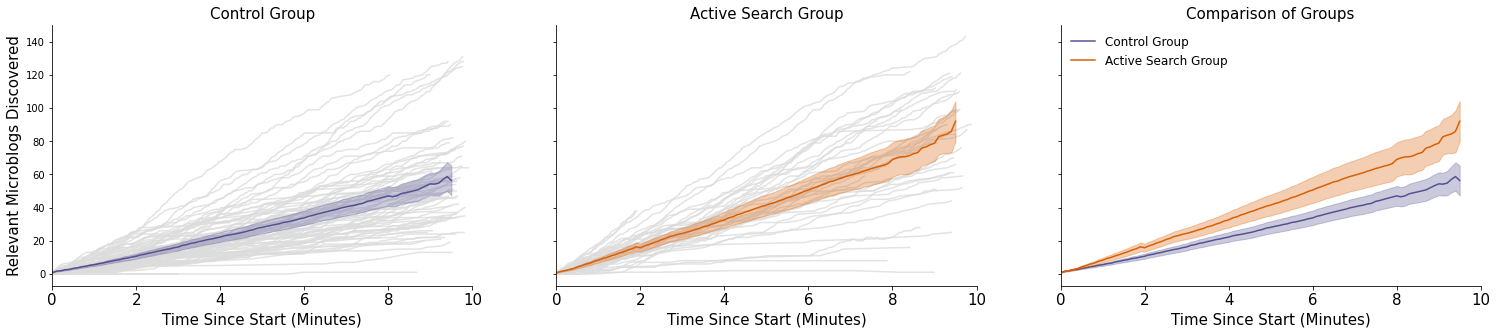

In [16]:
temp = df_sessions_1_filtered_2
bookmarks_df_plot = df_bookmarks_1[df_bookmarks_1.feedback=='bookmark'].join(temp[['active_search_condition', 'suggestion_bookmark']], on='session_id', rsuffix='_aggregate', how='inner')
time_limit = 9.6
bookmarks_df_plot = bookmarks_df_plot[bookmarks_df_plot.time_since_start < 10]

fig, (ax1, ax2, ax4) = plt.subplots(1, 3, sharey=True, figsize=(4*6.4, 4.8))
plt.rcParams.update({'axes.titlesize': 15, 'axes.labelsize': 15, 'xtick.labelsize':12, 'xtick.labelsize':12})

ax1= bookmarks_df_plot[bookmarks_df_plot['active_search_condition'] == 'control'].groupby(['session_id']).plot(x='time_since_start', y='current_positive_bookmark_count', ax=ax1, legend=False, grid=False, title='Control Group', color='gainsboro', alpha=0.8)
ax2= bookmarks_df_plot[(bookmarks_df_plot['active_search_condition'] == 'greedy') & (bookmarks_df_plot['suggestion_bookmark_aggregate'] != 0)].groupby(['session_id']).plot(x='time_since_start', y='current_positive_bookmark_count', ax=ax2, legend=False,  grid=False, title='Active Search Group', color='gainsboro', alpha=0.8)
#ax3= bookmarks_df_plot[(bookmarks_df_plot['active_search_condition'] == 'greedy') & (bookmarks_df_plot['suggestion_bookmark_aggregate'] == 0)].groupby(['session_id']).plot(x='time_since_start', y='current_unique_kw_count', ax=ax3, legend=False, grid=False, title='Active Search Group - Ignored Suggestions', color='lightgray', alpha=0.4)
ax1[0].set(xlabel='Time Since Start (Minutes)', ylabel='Number of Microblogs Discovered')
ax2[0].set(xlabel='Time Since Start (Minutes)')
#ax3[0].set(xlabel='Time Since Start (Minutes)')

ax4.set(title='Comparison of Groups')
ax4.grid(False)

for ax in [ax1[0], ax2[0], ax4]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.set(xlabel='Time Since Start (Minutes)', ylabel='Relevant Microblogs Discovered')
    ax.set_xlim((0, 10))

temp = bookmarks_df_plot[bookmarks_df_plot['active_search_condition'] == 'control'][['session_id', 'time_since_start', 'current_positive_bookmark_count', 'active_search_condition']]
temp['snapped_time_since_start'] = round(temp.time_since_start * 10)/10
control_bms = {}

sorted_time_stamps = np.sort(temp.snapped_time_since_start.unique())
selected_times = sorted_time_stamps<time_limit

for t in sorted_time_stamps:
    control_bms[t] = []
    ttt = temp[temp.snapped_time_since_start >= t]
    #print(t, ttt.session_id.unique().size)
    for session_id in ttt.session_id.unique():
        temp_session_df = ttt[ttt.session_id == session_id].reset_index()
        control_bms[t].append(temp_session_df.iloc[temp_session_df['time_since_start'].idxmin()].current_positive_bookmark_count)
    
means = np.array([np.mean(control_bms[t]) for t in sorted_time_stamps])[selected_times]
sems = np.array([st.sem(control_bms[t]) for t in sorted_time_stamps])[selected_times]
ax1[0].plot(sorted_time_stamps[selected_times], means, c='#555091')
ax1[0].fill_between(sorted_time_stamps[selected_times], means-2*sems, means+2*sems, color='#555091', alpha=0.3, zorder=150)

ax4.plot(sorted_time_stamps[selected_times], means, c='#555091', label='Control Group')  
ax4.fill_between(sorted_time_stamps[selected_times], means-2*sems, means+2*sems, color='#555091', alpha=0.3)

print('\n')
temp = bookmarks_df_plot[(bookmarks_df_plot['active_search_condition'] == 'greedy') & (bookmarks_df_plot['suggestion_bookmark_aggregate'] != 0)][['session_id', 'time_since_start', 'current_positive_bookmark_count', 'active_search_condition']]
temp['snapped_time_since_start'] = round(temp.time_since_start * 10)/10
as_bms = {}
for t in sorted_time_stamps:
    as_bms[t] = []
    ttt = temp[temp.snapped_time_since_start >= t]
    #print(t, ttt.session_id.unique().size)
    for session_id in ttt.session_id.unique():
        temp_session_df = ttt[ttt.session_id == session_id].reset_index()
        as_bms[t].append(temp_session_df.iloc[temp_session_df['time_since_start'].idxmin()].current_positive_bookmark_count)
    
means = np.array([np.mean(as_bms[t]) for t in sorted_time_stamps])[selected_times]
sems = np.array([st.sem(as_bms[t]) for t in sorted_time_stamps])[selected_times]
ax2[0].plot(sorted_time_stamps[selected_times], means, c='#d95f02')
ax2[0].fill_between(sorted_time_stamps[selected_times], means-2*sems, means+2*sems, color='#d95f02', alpha=0.3, zorder=100)

ax4.plot(sorted_time_stamps[selected_times], means, c='#d95f02', label='Active Search Group')  
ax4.fill_between(sorted_time_stamps[selected_times], means-2*sems, means+2*sems, color='#d95f02', alpha=0.3, zorder=100)
    
ax4.legend(fancybox=False, edgecolor='white', fontsize='large', loc=2)

plt.savefig('../figure_outputs/unique_bm_over_time_two_groups_experiment_1.png', dpi=300, transparent=True, bbox_inches = 'tight',pad_inches = 0)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


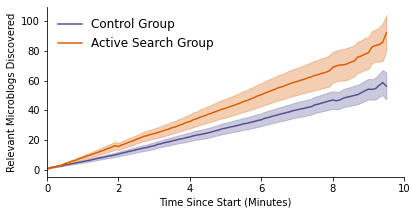

In [17]:
# Only considering subjects in the active search group (i.e. greedy)
plt.rcParams.update({'axes.titlesize': 15, 'axes.labelsize': 10, 'xtick.labelsize':10, 'xtick.labelsize':10})
plt_obj = plt.subplots(1, 1, figsize=(1*6.4, 0.65*4.8), sharex=True)
fig, ax = plt_obj

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.set(ylabel='Relevant Microblogs Discovered')
ax.set_xlim((0, 10))
ax.set(xlabel='Time Since Start (Minutes)')



#Exp 1
temp = df_sessions_1_filtered_2
bookmarks_df_plot = df_bookmarks_1[df_bookmarks_1.feedback=='bookmark'].join(temp[['active_search_condition', 'suggestion_bookmark']], on='session_id', rsuffix='_aggregate', how='inner')
time_limit = 9.6
bookmarks_df_plot = bookmarks_df_plot[bookmarks_df_plot.time_since_start < 10]
temp = bookmarks_df_plot[bookmarks_df_plot['active_search_condition'] == 'control'][['session_id', 'time_since_start', 'current_positive_bookmark_count', 'active_search_condition']]
temp['snapped_time_since_start'] = round(temp.time_since_start * 10)/10
control_bms = {}
sorted_time_stamps = np.sort(temp.snapped_time_since_start.unique())
selected_times = sorted_time_stamps<time_limit

for t in sorted_time_stamps:
    control_bms[t] = []
    ttt = temp[temp.snapped_time_since_start >= t]
    #print(t, ttt.session_id.unique().size)
    for session_id in ttt.session_id.unique():
        temp_session_df = ttt[ttt.session_id == session_id].reset_index()
        control_bms[t].append(temp_session_df.iloc[temp_session_df['time_since_start'].idxmin()].current_positive_bookmark_count)
    
means = np.array([np.mean(control_bms[t]) for t in sorted_time_stamps])[selected_times]
sems = np.array([st.sem(control_bms[t]) for t in sorted_time_stamps])[selected_times]
ax.plot(sorted_time_stamps[selected_times], means, c='#555091', label='Control Group')  
ax.fill_between(sorted_time_stamps[selected_times], means-2*sems, means+2*sems, color='#555091', alpha=0.3)

temp = bookmarks_df_plot[(bookmarks_df_plot['active_search_condition'] == 'greedy') & (bookmarks_df_plot['suggestion_bookmark_aggregate'] != 0)][['session_id', 'time_since_start', 'current_positive_bookmark_count', 'active_search_condition']]
temp['snapped_time_since_start'] = round(temp.time_since_start * 10)/10
as_bms = {}
for t in sorted_time_stamps:
    as_bms[t] = []
    ttt = temp[temp.snapped_time_since_start >= t]
    #print(t, ttt.session_id.unique().size)
    for session_id in ttt.session_id.unique():
        temp_session_df = ttt[ttt.session_id == session_id].reset_index()
        as_bms[t].append(temp_session_df.iloc[temp_session_df['time_since_start'].idxmin()].current_positive_bookmark_count)
    
means = np.array([np.mean(as_bms[t]) for t in sorted_time_stamps])[selected_times]
sems = np.array([st.sem(as_bms[t]) for t in sorted_time_stamps])[selected_times]
ax.plot(sorted_time_stamps[selected_times], means, c='#d95f02', label='Active Search Group')  
ax.fill_between(sorted_time_stamps[selected_times], means-2*sems, means+2*sems, color='#d95f02', alpha=0.3, zorder=100) 
ax.legend(fancybox=False, edgecolor='white', fontsize='large', loc=2)

plt.rcParams.update({'axes.titlesize': 12, 'axes.labelsize': 12, 'xtick.labelsize':12})
plt.savefig('../figure_outputs/unique_bm_over_time_comparison_only_ex1.png', dpi=300, transparent=True, bbox_inches = 'tight',pad_inches = 0)

<a id='s44'></a>
### Survey Response Visualization

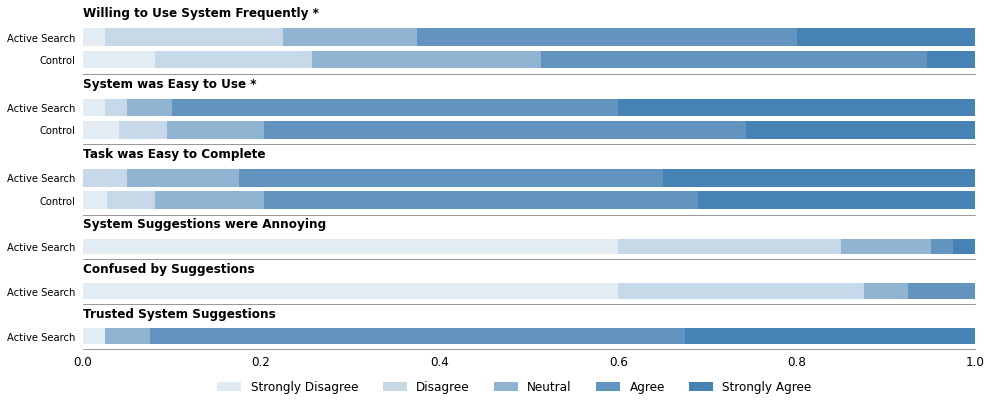

In [18]:
temp = df_sessions_1_filtered_2
temp['Experimental Group'] = temp.apply(lambda row: 'Control' if row.active_search_condition == 'control' else 'Active Search' if row.active_search_condition == 'greedy' and row.suggestion_bookmark != 0 else 'Active Search - Ignored Suggestions', axis=1)
questions = {'q1': 'Willing to Use System Frequently *', 'q2':'System was Easy to Use *', 'q3': 'Task was Easy to Complete', 'q5': 'System Suggestions were Annoying', 'q6': 'Confused by Suggestions', 'q7': 'Trusted System Suggestions'}

temp = temp.rename(columns=questions)
plt_obj = plt.subplots(6, 1, sharex=True, figsize=(2.5*6.4, 1.25*4.8),  gridspec_kw={'height_ratios': [4, 4, 4, 2, 2, 2]})
fig1, axss = plt_obj
ax1, ax2, ax3, ax4, ax5, ax6 = axss
plt.xlim([0,1])
# plt.yticks([1,2,3,4,5], ['Strongly Disagree', 'Disagree', 'Neutral', 'Agree', 'Strongly Agree'])

questions = {'q1': ('Willing to Use System Frequently *', ax1), 'q2': ('System was Easy to Use *', ax2), 
             'q3': ('Task was Easy to Complete', ax3), 'q5': ('System Suggestions were Annoying', ax4), 
             'q6': ('Confused by Suggestions', ax5), 'q7': ('Trusted System Suggestions', ax6)}


for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('gray')

bar_height = 0.3
for qj in questions:
    q = questions[qj][0]
    a = questions[qj][1]
    
    if qj in ['q1', 'q2', 'q3']:
        groups = ['Control', 'Active Search']
        bar_height = 0.8
    else:
        groups = ['Active Search']
        bar_height = 0.8
    props = {1: [], 2: [], 3: [], 4: [], 5:[]}
    for group in groups:
        c = temp[temp['Experimental Group'] == group][q].value_counts(normalize=True)
        for i in props.keys():
            try:
                props[i].append(c[i])
            except:
                props[i].append(0)
                
    ndf = pd.DataFrame(props, index=groups)
    ndf = ndf.rename(columns={5: 'Strongly Agree', 4: 'Agree', 3: 'Neutral', 2: 'Disagree', 1: 'Strongly Disagree'})
    ndf.plot.barh(ax=a, stacked=True, color=[mpc.to_rgba('steelblue', 0.15), mpc.to_rgba('steelblue', 0.3), mpc.to_rgba('steelblue', 0.6), mpc.to_rgba('steelblue', 0.85), mpc.to_rgba('steelblue', 1)], legend=False, grid=False, rot=0, width=bar_height)
    a.set_title(q, fontweight='bold', fontsize=12, loc='left')
    a.tick_params(axis = "x", which = "both", bottom = False, top = False)
    a.tick_params(axis = "y", which = "both", left = False)
handles, labels = ax1.get_legend_handles_labels()
fig1.subplots_adjust(hspace=0.5)

fig1.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,0.01), ncol=5, borderpad=0.5, borderaxespad=-0.1, fancybox=False, edgecolor='white', fontsize='large')
    
plt.savefig('../figure_outputs/survey_results_1_two_groups.png' , dpi=300, transparent=False, facecolor='white', bbox_inches = 'tight', pad_inches = 0)

<a id='s46'></a>
### Survey Response Statistical Test

In [19]:
temp = df_sessions_1_filtered_2
temp['Experimental Group'] = temp.apply(lambda row: 'Control' if row.active_search_condition == 'control' else 'Active Search' if row.active_search_condition == 'greedy' and row.suggestion_bookmark != 0 else 'Active Search - Ignored Suggestions', axis=1)
questions = {'q1': 'Willing to Use System Frequently', 'q2':'System was Easy to Use', 'q3': 'Task was Easy to Complete', 'q5': 'System Suggestions were Annoying', 'q6': 'Confused by Suggestions', 'q7': 'Trusted System Suggestions'}

#temp = temp.rename(columns=questions)

for qj in questions:
    q = questions[qj][0]
    a = questions[qj][1]
    
    if qj in ['q1', 'q2', 'q3']:
        print(f'{qj}: {questions[qj]}')

        g1 = temp[temp['Experimental Group'] == 'Control'][qj].to_numpy()
        g2 = temp[temp['Experimental Group'] == 'Active Search'][qj].to_numpy()
        print(f'N Control = {len(g1)}; N Active Search{len(g2)}')
        
        print(f'Control CI: {g1.mean()} +/- {1.96*st.sem(g1)}')
        print(f'Active Search CI: {g2.mean()} +/- {1.96*st.sem(g2)}')
        
        t, p = st.mannwhitneyu(g1, g2)
        print(f'p-value={p:.4f}')
        print(f'U-statistic: {t:.2f}')
        
        z = (g2.mean() - g1.mean())/(np.sqrt(np.var(g2)/len(g2) + np.var(g1)/len(g1)))
        print(f'Standardized Test Statistic: {z}')
        
        print(f'Effect Size: {z/np.sqrt(len(g1) + len(g2))}')
        
        print('\n\n')


q1: Willing to Use System Frequently
N Control = 74; N Active Search40
Control CI: 3.2027027027027026 +/- 0.24142282314874125
Active Search CI: 3.575 +/- 0.34299999999999997
p-value=0.0362
U-statistic: 1192.00
Standardized Test Statistic: 1.7584212577502107
Effect Size: 0.16469124007924843



q2: System was Easy to Use
N Control = 74; N Active Search40
Control CI: 3.918918918918919 +/- 0.22233784989353933
Active Search CI: 4.225 +/- 0.2671194393371528
p-value=0.0336
U-statistic: 1199.50
Standardized Test Statistic: 1.7439572291232297
Effect Size: 0.16333655968021424



q3: Task was Easy to Complete
N Control = 74; N Active Search40
Control CI: 4.0 +/- 0.21664603704748922
Active Search CI: 4.125 +/- 0.25485315027507155
p-value=0.2989
U-statistic: 1397.50
Standardized Test Statistic: 0.7399563438635302
Effect Size: 0.06930326128524474





<a id='s45'></a>
### Geo-spatial and Keyword Coverage Figures

155.61958793966215


/var/folders/vn/j4d_9bm174550z7r0ht_vc7w0000gn/T/ipykernel_68154/1814674861.py:203: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  divnorm = mpc.DivergingNorm(vmin=rel_min, vcenter=1, vmax=rel_max)


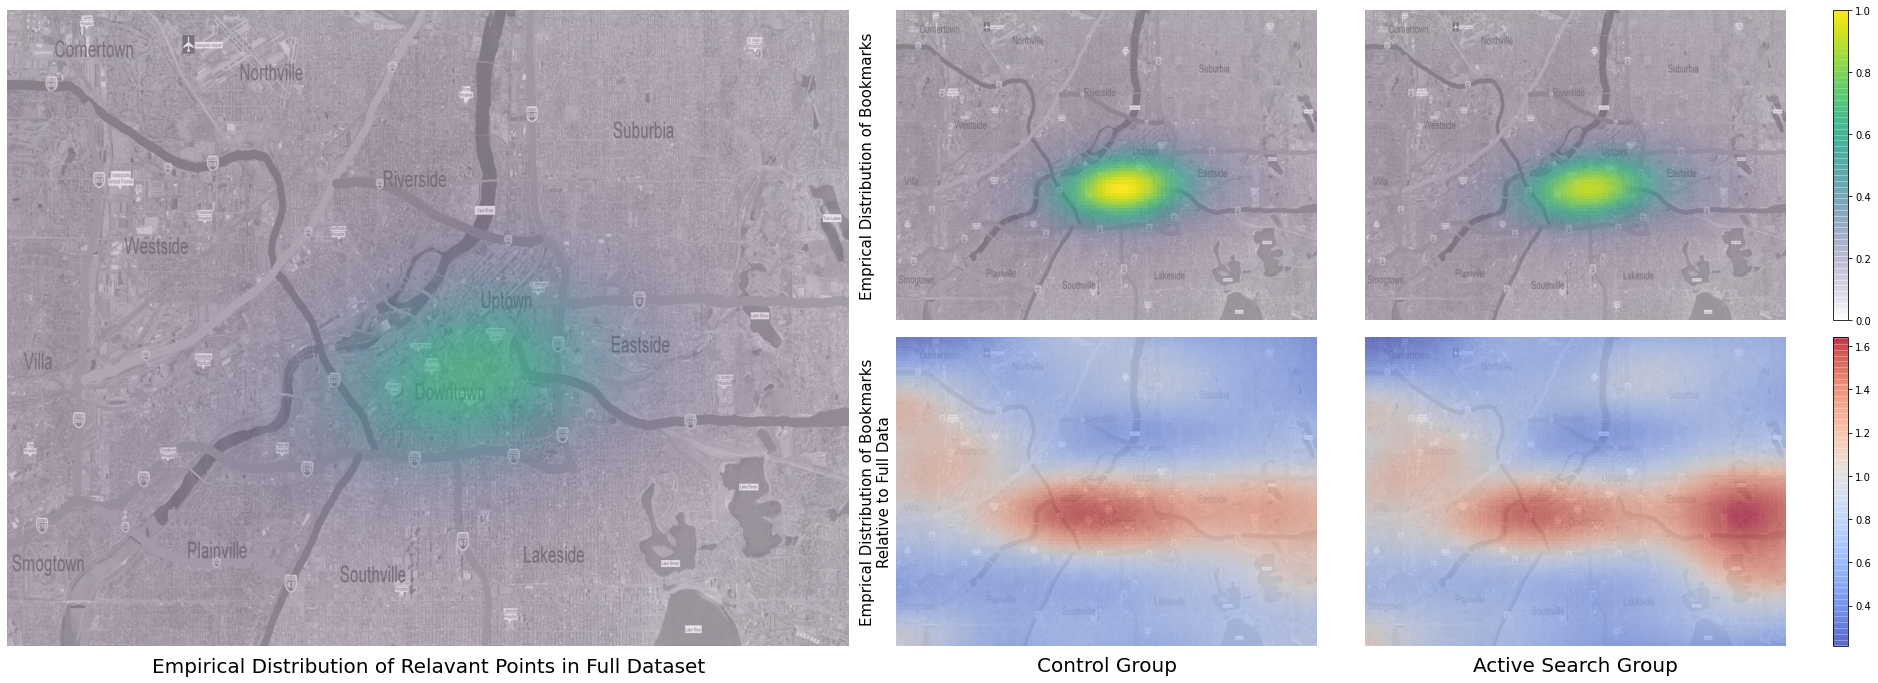

In [20]:
global_relevant_points = all_data_microblogs
global_relevant_points = global_relevant_points[global_relevant_points['label'] == 1]
global_relevant_ids = global_relevant_points.post_id.to_list()
global_relevant_loc = global_relevant_points[['latitude', 'longitude']]

bw = 0.5

dot_size=0.5
global_locs=global_relevant_loc
color='lightblue'


global_x = (-1*global_locs.longitude).to_list()
global_y = global_locs.latitude.to_list()
# Define the borders
xmin = min(global_x)
xmax = max(global_x)
ymin = min(global_y)
ymax = max(global_y)


# get colormap
ncolors = 256
color_array = plt.get_cmap('viridis')(range(ncolors))

# change alpha values
color_array[:,-1] = np.linspace(0, 1,ncolors)

# create a colormap object
map_object = mpc.LinearSegmentedColormap.from_list(name='viridis_alpha',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)
    
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([xx.ravel(), yy.ravel()])


def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

img=mpimg.imread('../data/user_study/Vastopolis_Map.png')
img=rgb2gray(img)
        
figcount = 3
    
fig1= plt.figure(figsize=((figcount + 1.1)*6.4, 2*4.8))
#plt.subplots_adjust(hspace=0.01, vspace=0.1)
gs = fig1.add_gridspec(2, figcount+1, width_ratios=[2,1,1,0.1])

axs = [fig1.add_subplot(gs[:, 0]), fig1.add_subplot(gs[0, 1]), fig1.add_subplot(gs[0, 2]), fig1.add_subplot(gs[0, 3])]
for ax in axs:
    ax.grid(False)
    # ax.axis(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    
axs[1].set_ylabel('Emprical Distribution of Bookmarks\n', fontsize=15, rotation=90)

for ax in axs[:-1]:
    ax.imshow(img, alpha=0.5, extent=(xmin, xmax, ymin, ymax), aspect='auto', cmap='gray')
    ax.imshow(np.ones((1,1,1)), alpha=0.1, extent=(xmin, xmax, ymin, ymax), aspect='auto')

x = global_x
y = global_y
values = np.vstack([x, y]) 
global_kernel = st.gaussian_kde(values, bw_method=bw)
global_f = np.reshape(global_kernel(positions), xx.shape)
axs[0].set_title('Empirical Distribution of Relavant Points in Full Dataset', y=-0.05, fontsize=20)


control_sessions = df_sessions_1_filtered_2[df_sessions_1_filtered_2['active_search_condition']=='control']['current_bookmark_list'].reset_index(drop=True)
relevant_ids = []
for session in control_sessions:
    relevant_ids += session
    
relevant_ids = np.unique(relevant_ids)
relevant_points = all_data_microblogs.loc[relevant_ids]
control_session_points = relevant_points[relevant_points.label==1]
#im = plot_dots(relevant_loc, dot_size=5, ax=axs[1], normalize=True)
#plot_cloud(relevant_wrd, ax=axs[1][1])

x = (-1*control_session_points.longitude).to_list()
y = control_session_points.latitude.to_list()
values = np.vstack([x, y]) 
control_kernel = st.gaussian_kde(values, bw_method=bw)
control_f = np.reshape(control_kernel(positions), xx.shape)

#axs[1].set_title('Control Group', y=-0.1, fontsize=20)


###### AS-U

sessions = df_sessions_1_filtered_2[df_sessions_1_filtered_2['active_search_condition']=='greedy']['current_bookmark_list'].reset_index(drop=True)
relevant_ids = []
for session in sessions:
    relevant_ids += session
    
relevant_ids = np.unique(relevant_ids)
relevant_points = all_data_microblogs.loc[relevant_ids]
session_points = relevant_points[relevant_points.label==1]
#im = plot_dots(relevant_loc, dot_size=5, ax=axs[1], normalize=True)
#plot_cloud(relevant_wrd, ax=axs[1][1])

x = (-1*session_points.longitude).to_list()
y = session_points.latitude.to_list()

values = np.vstack([x, y]) 
asu_kernel = st.gaussian_kde(values, bw_method=bw)
asu_f = np.reshape(asu_kernel(positions), xx.shape)
#axs[2].set_title('Active Search Group - Used Suggestions', y=-0.1, fontsize=20)



max_density_value = np.max([np.abs(asu_f), np.abs(control_f), np.abs(global_f)])
print(max_density_value)

global_f /= max_density_value
control_f /= max_density_value
asu_f /= max_density_value

#control_f = np.divide(control_f, global_f)
#asu_f = np.divide(asu_f, global_f)
#asi_f = np.divide(asi_f, global_f)

axs[0].imshow(np.rot90(global_f), vmin=0, vmax=1, extent=(xmin, xmax, ymin, ymax), cmap='viridis_alpha', aspect='auto')
axs[1].imshow(np.rot90(control_f), vmin=0, vmax=1, extent=(xmin, xmax, ymin, ymax), cmap='viridis_alpha', aspect='auto')
im = axs[2].imshow(np.rot90(asu_f), vmin=0, vmax=1, extent=(xmin, xmax, ymin, ymax), cmap='viridis_alpha', aspect='auto')

fig1.colorbar(im, ax=axs[-1], fraction=1)
fig1.tight_layout()
# plt.savefig('./combined_heat_sample.png', dpi=300, transparent=True, bbox_inches = 'tight',pad_inches = 0)



############################## RATIOS

    
# fig1, axs = plt.subplots(1, 5, figsize=(5*6.4, 1*4.8))
axs = [fig1.add_subplot(gs[1, 1]), fig1.add_subplot(gs[1, 2]), fig1.add_subplot(gs[1, 3])]
#plt.subplots_adjust(hspace=0.01)

for ax in axs:
    ax.grid(False)
    # ax.axis(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

axs[0].set_ylabel('Emprical Distribution of Bookmarks\nRelative to Full Data', fontsize=15, rotation=90)


for ax in axs[0:2]:
    ax.imshow(img, alpha=0.5, extent=(xmin, xmax, ymin, ymax), aspect='auto', cmap='gray')
    ax.imshow(np.ones((1,1,1)), alpha=0.1, extent=(xmin, xmax, ymin, ymax), aspect='auto')



axs[0].set_title('Control Group', y=-0.1, fontsize=20)


###### AS-U

axs[1].set_title('Active Search Group', y=-0.1, fontsize=20)






control_f_rel = np.divide(control_f, global_f)
asu_f_rel = np.divide(asu_f, global_f)

#control_f_rel = np.log(control_f_rel)
#asu_f_rel = np.log(asu_f_rel)
#asi_f_rel = np.log(asi_f_rel)

max_value = np.max([control_f_rel, asu_f_rel])

#control_f_rel /= max_value
#asu_f_rel /= max_value
#asi_f_rel /= max_value

rel_min = np.min([control_f_rel, asu_f_rel])
rel_max = np.max([control_f_rel, asu_f_rel])

colors_under = plt.cm.coolwarm(np.linspace(0, 0.5, 256))
colors_over = plt.cm.coolwarm(np.linspace(0.5, 1, 256))
all_colors = np.vstack((colors_under, colors_over))
color_map = mpc.LinearSegmentedColormap.from_list('coolwarm', all_colors)

# make the norm:  Note the center is offset so that the land has more
# dynamic range:
divnorm = mpc.DivergingNorm(vmin=rel_min, vcenter=1, vmax=rel_max)

# axs[0].imshow(np.rot90(global_f), alpha=5, extent=(xmin, xmax, ymin, ymax), cmap='viridis', aspect='auto')
axs[0].imshow(np.rot90(control_f_rel), alpha=0.6, extent=(xmin, xmax, ymin, ymax), cmap=color_map, norm=divnorm, aspect='auto')
im = axs[1].imshow(np.rot90(asu_f_rel), alpha=0.6, extent=(xmin, xmax, ymin, ymax), cmap=color_map, norm=divnorm, aspect='auto')
#axs[3].imshow(np.rot90(asi_f_rel), alpha=0.6, extent=(xmin, xmax, ymin, ymax), cmap=color_map, norm=divnorm, aspect='auto')


fig1.colorbar(im, ax=axs[-1], fraction=1)
fig1.tight_layout()
plt.savefig('../figure_outputs/heatmaps_two_group_exp1.png', dpi=300, transparent=True, bbox_inches = 'tight',pad_inches = 0)   